##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Gemini 2.0 - Grounding using Search as a tool

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Search_Grounding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

In this notebook you will learn how to use the new Google Search tool available in [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2), using both the unary API and the Multimodal Live API. Check out the docs to learn more about using [Search as a tool](https://ai.google.dev/gemini-api/docs/models/gemini-v2#search-tool).

Note that the previous version of this guide using Gemini models priori to 2.0 and the legacy SDK can still be found [here](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Search_Grounding.ipynb).

## Set up the SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini 2.0 models.

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](./Get_started.ipynb) notebook.

In [1]:
%pip install -q -U "google-genai>=1.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 4.7 MB/s eta 0:00:00


### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [2]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

### Select model and initialize SDK client

The client will pick up your API key from the environment variable.
To use the live API you need to set the client version to `v1alpha` and use the Gemini 2.0 model.

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](./Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).

In [3]:
from google import genai

client = genai.Client() # the API is automatically loaded from the environement variable

MODEL_ID = "gemini-2.5-flash-preview-04-17" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}

## Use Google Search
Search grounding is particularly useful for queries that require current information or external knowledge. Using Google Search, Gemini can access nearly real-time information and better responses.

In [9]:
from IPython.display import HTML, Markdown

# response = client.models.generate_content(
#     model=MODEL_ID,
#     contents='What was the latest Indian Premier League match and who won?',
#     config={"tools": [{"google_search": {}}]},
# )

response = client.models.generate_content(
    model=MODEL_ID,
    contents='What many hai di laos in Singapore?',
    config={"tools": [{"google_search": {}}]},
)

# print the response
display(Markdown(f"Response:\n {response.text}"))
# print the search details
print(f"Search Query: {response.candidates[0].grounding_metadata.web_search_queries}")
# urls used for grounding
print(f"Search Pages: {', '.join([site.web.title for site in response.candidates[0].grounding_metadata.grounding_chunks])}")

display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

Response:
 As of early 2025, there are 20 Haidilao outlets located across Singapore.

Search Query: ['how many hai di lao outlets in singapore', 'Hai Di Lao Singapore locations number']
Search Pages: cheapandgood.sg


The information provided may be outdated, as it is based on a knowledge cutoff. For the most current and authoritative details, please refer to the official [Model documentation](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25), which includes the latest knowledge cutoff date.

You can see that running the same prompt without search grounding gives you outdated information:

In [8]:
from IPython.display import Markdown

# response = client.models.generate_content(
#     model=MODEL_ID,
#     contents='What was the latest Indian Premier League match and who won?',
# )

response = client.models.generate_content(
    model=MODEL_ID,
    contents='How many hai di laos in singapore?',
)


# print the response
display(Markdown(response.text))

As of early 2024, there are **18** Hai Di Lao outlets located across Singapore.

Please note that this number can change if they open new branches.

## Use search in chat

Start by defining a helper function that you will use to display each part of the returned response.

In [13]:
# @title Define some helpers (run this cell)
import json

from IPython.display import display, HTML, Markdown


def show_json(obj):
  print(json.dumps(obj.model_dump(exclude_none=True), indent=2))

def show_parts(r):
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return
  for part in r.candidates[0].content.parts:
    if part.text:
      display(Markdown(part.text)) ### Highlight— render text.
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```')) ### Highlight- display code
    else:
      show_json(part)

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


First try a query that needs realtime information, so you can see how the model performs _without_ Google Search.

In [15]:
chat = client.chats.create(model=MODEL_ID)

# response = chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')
response = chat.send_message('What was the most recent IPL match?')

show_parts(response)

The most recent IPL match played was the **Final of the IPL 2024 season**.

It was played between:
*   **Kolkata Knight Riders (KKR)** and
*   **Sunrisers Hyderabad (SRH)**

This match took place on **May 26, 2024**. KKR won this match and the 2024 IPL title. The 2024 season is now concluded.

Now set up a new chat session that uses the `google_search` tool.  The `show_parts` helper will display the text output as well as any Google Search queries used in the results.

In [16]:
search_tool = {'google_search': {}}

soccer_chat = client.chats.create(
    model=MODEL_ID,
    config={'tools': [search_tool]}
)

response = soccer_chat.send_message('What was the most recent IPL match?')

show_parts(response)

As of May 9, 2025, the Indian Premier League (IPL) 2025 season has been suspended for one week due to rising tensions between India and Pakistan.

Before the suspension, 58 matches had been completed, including an abandoned fixture. The most recent completed matches before the suspension were:

*   **May 7, 2025:** Kolkata Knight Riders vs Chennai Super Kings in Kolkata. Kolkata Knight Riders won.
*   **May 6, 2025:** Mumbai Indians vs Gujarat Titans in Mumbai. Gujarat Titans won by 3 wickets (DLS method).
*   **May 5, 2025:** Delhi Capitals vs Sunrisers Hyderabad in Hyderabad. This match had no result.
*   **May 4, 2025:** Punjab Kings vs Lucknow Super Giants in Dharamsala. Punjab Kings won by 37 runs.

The match on May 8, 2025, between Punjab Kings and Delhi Capitals in Dharamsala was abandoned due to security concerns.

A revised schedule for the remaining matches and playoffs is expected to be announced by the BCCI in due course.

As you are using a `chat` session, you can ask the model follow-up questions too.

In [18]:
response = soccer_chat.send_message('Who scored the wickets?')

show_parts(response)

You're right to ask about wickets in cricket! Here's a breakdown of who took wickets in the most recent completed IPL matches before the suspension:

**Kolkata Knight Riders vs Chennai Super Kings (May 7, 2025)**

In this match, where Chennai Super Kings won by 2 wickets, the wickets were taken by bowlers from both teams.
*   For Kolkata Knight Riders, Vaibhav Arora took 3 wickets, while Harshit Rana and Varun Chakaravarthy each took 2 wickets. Moeen Ali and Ravindra Jadeja each claimed 1 wicket.
*   For Chennai Super Kings, the scorecard shows wickets falling to various KKR bowlers.

**Mumbai Indians vs Gujarat Titans (May 6, 2025)**

Gujarat Titans won this match by 3 wickets (DLS method).
*   For Mumbai Indians, Trent Boult took 2 wickets, and Jasprit Bumrah also claimed 2 wickets. Ashwani Kumar took 2 wickets, and Deepak Chahar took 1 wicket.
*   For Gujarat Titans, all their bowlers picked up at least a wicket. Sai Kishore took 2 wickets, and Gerald Coetzee took 1 wicket.

**Delhi Capitals vs Sunrisers Hyderabad (May 5, 2025)**

This match was abandoned due to rain. Before the abandonment, Delhi Capitals had batted.
*   For Sunrisers Hyderabad, Pat Cummins took 3 wickets. Jaydev Unadkat, Harshal Patel, and Eshan Malinga each took 1 wicket.

**Punjab Kings vs Lucknow Super Giants (May 4, 2025)**

Punjab Kings won this match by 37 runs.
*   For Lucknow Super Giants, Akash Singh took 2 wickets and Digvesh Singh took 2 wickets. Prince Yadav and Mayank Yadav each claimed 1 wicket.
*   For Punjab Kings, Arshdeep Singh was the top wicket-taker with 3 wickets. Azmatullah Omarzai took 2 wickets, and Marco Jansen and Yuzvendra Chahal each took 1 wicket.

## Plot search results


In this example you can see how to use the Google Search tool with code generation in order to plot results.

In [23]:
movie_chat = client.chats.create(
    model=MODEL_ID,
    config={'tools': [search_tool]}
)

response = movie_chat.send_message('Generate some Python code to plot the wins of the IPL teams so far.')

show_parts(response)

Here's some Python code using `matplotlib` and `pandas` to create a bar plot of the total wins for IPL teams based on historical data.



```python
import matplotlib.pyplot as plt
import pandas as pd

# Data on IPL teams and their total wins (based on search results up to IPL 2024)
# This data is compiled from the search results, primarily [2, 4, 5]
data = {'Team': ['Mumbai Indians', 'Chennai Super Kings', 'Kolkata Knight Riders',
                 'Delhi Capitals', 'Punjab Kings', 'Rajasthan Royals',
                 'Royal Challengers Bengaluru', 'Sunrisers Hyderabad',
                 'Gujarat Titans', 'Lucknow Super Giants', 'Deccan Chargers',
                 'Rising Pune Supergiant', 'Gujarat Lions', 'Kochi Tuskers Kerala',
                 'Pune Warriors India'],
        'Wins': [149, 141, 135, 118, 116, 113, 129, 98, 36, 29, 29, 15, 13, 6, 12] # Approximate wins based on available data, some teams are defunct
       }

df = pd.DataFrame(data)

# Sort by wins in descending order
df = df.sort_values('Wins', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 8))
plt.bar(df['Team'], df['Wins'], color='skyblue')
plt.xlabel('IPL Teams')
plt.ylabel('Number of Wins')
plt.title('Total IPL Wins per Team (Historical Data)')
plt.xticks(rotation=90) # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()
```



**Explanation:**

1.  **Import Libraries:** Imports `matplotlib.pyplot` for plotting and `pandas` for data manipulation.
2.  **Data:** A dictionary `data` is created to store team names and their approximate total wins. The win data is compiled from the provided search results. Note that some teams are defunct and their final win counts are included.
3.  **Pandas DataFrame:** The data is converted into a pandas DataFrame for easier handling.
4.  **Sort Data:** The DataFrame is sorted in descending order based on the 'Wins' column to display the teams with the most wins first.
5.  **Create Bar Plot:**
    *   `plt.figure(figsize=(12, 8))` sets the size of the plot.
    *   `plt.bar(df['Team'], df['Wins'], color='skyblue')` creates the bar plot with team names on the x-axis and wins on the y-axis.
    *   Labels and a title are added for clarity.
    *   `plt.xticks(rotation=90)` rotates the team names on the x-axis to prevent overlapping, as there are many teams.
    *   `plt.tight_layout()` adjusts the plot to make sure everything fits well.
    *   `plt.show()` displays the plot.

This code will generate a bar chart showing the historical wins of various IPL teams based on the provided data. Mumbai Indians and Chennai Super Kings are shown to be the most successful teams with five titles each. Kolkata Knight Riders are in second place with three titles. Rajasthan Royals, Deccan Chargers, Sunrisers Hyderabad, and Gujarat Titans have each won one title. Deccan Chargers are now defunct.

First review the supplied code to make sure it does what you expect, then copy it here to try out the chart.

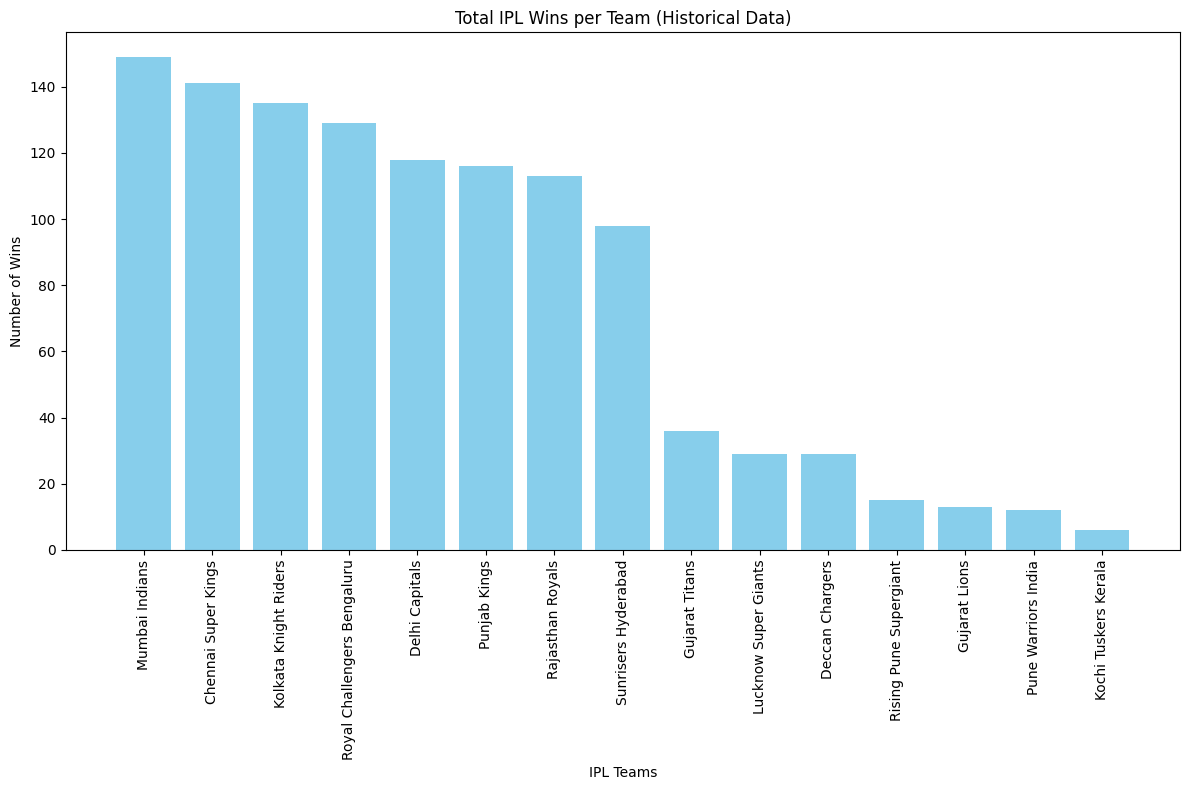

In [24]:
import re

matchFound = re.search(r"python\n(.*?)```", response.text, re.DOTALL)

if matchFound:
  code = matchFound.group(1)
  exec(code)

One feature of using a chat conversation to do this is that you can now ask the model to make changes.

In [32]:
response = movie_chat.send_message('Looks great! Can you give the chart a dark theme instead?')

show_parts(response)

Okay, you got it! We can use Matplotlib's built-in styles to easily switch to a dark theme. The `dark_background` style is perfect for this.

Here's the updated Python code with the dark theme applied:



```python
import matplotlib.pyplot as plt
import pandas as pd

# Data on IPL teams and their total wins (based on available historical data up to IPL 2024)
# Note: This data includes some defunct teams for historical context.
data = {'Team': ['Mumbai Indians', 'Chennai Super Kings', 'Kolkata Knight Riders',
                 'Delhi Capitals', 'Punjab Kings', 'Rajasthan Royals',
                 'Royal Challengers Bengaluru', 'Sunrisers Hyderabad',
                 'Gujarat Titans', 'Lucknow Super Giants', 'Deccan Chargers',
                 'Rising Pune Supergiant', 'Gujarat Lions', 'Kochi Tuskers Kerala',
                 'Pune Warriors India'],
        'Wins': [149, 141, 135, 118, 116, 113, 129, 98, 36, 29, 29, 15, 13, 6, 12]
       }

df = pd.DataFrame(data)

# Sort by wins in descending order
df = df.sort_values('Wins', ascending=False)

# Apply the 'dark_background' style for a dark theme
plt.style.use('dark_background') [1, 4, 5, 6]

# Create the bar plot
plt.figure(figsize=(12, 8))
plt.bar(df['Team'], df['Wins'], color='skyblue')
plt.xlabel('IPL Teams')
plt.ylabel('Number of Wins')
plt.title('Total IPL Wins per Team (Historical Data)')
plt.xticks(rotation=90) # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()
```



**Key Change:**

The line `plt.style.use('dark_background')` is added before the plotting code. This function applies the specified style settings to your plot, giving it a dark background and adjusting other elements like text and axes colors to ensure good contrast and readability.

Now, when you run this code, the generated bar chart will have a sleek dark theme. Matplotlib has a list of available styles, which you can view using `plt.style.available`. Besides `dark_background`, other styles like 'seaborn-darkgrid' or custom styles you create or download can also provide dark themes.

Again, always be sure to review code generated by the model before running it.

In [35]:
import re

matchFound = re.search(r"python\n(.*?)```", response.text, re.DOTALL)

if matchFound:
  code = matchFound.group(1)
  exec(code)

TypeError: 'NoneType' object is not subscriptable

## Use search in the Multimodal Live API

The Search tool can be used in a live streaming context to have the model formulate grounded responses during the conversation.

In [42]:
# Live API only works with v1alpha API and with the gemini-2.0-flash-exp model at the moment

client = genai.Client(http_options={'api_version': 'v1alpha'})

LIVE_MODEL_ID = "gemini-2.0-flash-exp"

### Define some helpers

To use the bi-directional streaming API in Colab, you will buffer the audio stream. Define a `play_response` helper function to do the buffering, and once the audio for the current turn has completed, display an IPython audio widget.

As each of the following examples only use a single prompt, also define a `run` helper to wrap the setup and prompt execution steps into a single function call. This helper takes a `config` argument that will be added to the `generation_config`, so that you can toggle the Search tool between examples.

In [41]:
# @title Helper functions for the Live API (run this cell)

import asyncio
import io
import json
import re
import time
import wave

import numpy as np
from IPython.display import Audio, display


DEFAULT_OUTPUT_RATE = 24000
BASE_MODEL_CONFIG = {
    # Here you can change the model's output mode between either audio or text.
    # While this code expects an audio stream, text should work, but the stream
    # may interleave with the `Buffering....` text.
    'response_modalities': ['AUDIO']
}

async def play_response(stream):
  """Buffer audio output and display a widget. Returns the streamed responses."""
  turn_buf = io.BytesIO()
  sample_rate = DEFAULT_OUTPUT_RATE

  all_responses = []

  print('Buffering', end='')
  async for msg in stream.receive():
    all_responses.append(msg)

    if text:=msg.text:
      print(text)
    if audio_data := msg.data:
      turn_buf.write(audio_data)
      if m := re.search(
          'rate=(?P<rate>\d+)',
          msg.server_content.model_turn.parts[0].inline_data.mime_type
      ):
            sample_rate = int(m.group('rate'))

    elif tool_call := msg.tool_call:
      # Handle tool-call requests. Here is where you would implement
      # custom tool code, but for this example, all tools respond 'ok'.
      for fc in tool_call.function_calls:
        print('Tool call', end='')
        tool_response = genai.types.LiveClientToolResponse(
            function_responses=[genai.types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': 'ok'},
            )]
        )
        await stream.send(input=tool_response)

    print('.', end='')

  print()

  # Play the audio
  if turn_buf.tell():
    audio = np.frombuffer(turn_buf.getvalue(), dtype=np.int16)
    display(Audio(audio, autoplay=True, rate=sample_rate))
  else:
    print('No audio :(')
    print(f'  {len(all_responses)=}')

  return all_responses


async def run(query, config=None):
  # Add any tools or other generation config.
  config = BASE_MODEL_CONFIG | (config or {})

  # Establish a live session. While this context manager is active, the
  # conversation will continue.
  async with client.aio.live.connect(model=LIVE_MODEL_ID, config=config) as strm:

    # Send the prompt.
    await strm.send(input=query, end_of_turn=True)
    # Handle the model response.
    responses = await play_response(strm)

    return responses

### Stream with the Search tool

First, execute a query _without_ the Search tool to observe the model's response to a time-sensitive query.

Note that the Multimodal Live API is a 2-way streaming API, but to simplify running in a notebook, each audio response is buffered and played once it has been fully streamed, so you will need to wait a few seconds before the response starts to play.

In [43]:
await run('Who won the last ipl match?');

<ipython-input-41-8d15eaa56993>:81: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await strm.send(input=query, end_of_turn=True)


Buffering

.......

.......

........

.......

........


Now re-run with the Search tool enabled.

In [44]:
responses = await run('Who won the last ipl match?', {'tools': [search_tool]})

<ipython-input-41-8d15eaa56993>:81: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await strm.send(input=query, end_of_turn=True)


Buffering

.

.

.......

.......

....

.......

.......

.......

......

.......

.......

.......

.......

........

.......

.......

.......

.....


If you wish to see the full output that was returned, you can enable `show_output` here and run this cell. It includes the complete audio binary data, so it is off by default.

In [46]:
show_output = False

if show_output:
  for msg in responses:
    print(msg.model_dump(exclude_none=True))

### Search with custom tools

In the Multimodal Live API, the Search tool can be used in conjunction with other tools, including function calls that you provide to the model.

In this example, you define a function `set_climate` that takes 2 parameters, `mode` (`hot`, `cold`, etc) and `strength` (0-10), and ask the model to set the climate control based on the live weather in the location you specify.

In [47]:
set_climate_tool = {'function_declarations': [{
    'name': 'set_climate',
    'description': 'Switches the local climate control equipment to the specified parameters.',
    'parameters': {
      'type': 'OBJECT',
      'properties': {
        # Define the "mode" argument.
        'mode': {
            'type': 'STRING',
            'enum': [
              # Define the possible values for "mode".
              "hot",
              "cold",
              "fan",
              "off",
            ],
            'description': 'Mode for the climate unit - whether to heat, cool or just blow air.',
        },
        # Define the "strength" argument.
        'strength': {
            'type': 'INTEGER',
            'description': 'Intensity of the climate to apply, 0-10 (0 is off, 10 is MAX).',
        },
      },
    },
  },
]}

search_tool = {'google_search': {}}

tools = {'tools': [search_tool, set_climate_tool]}

responses = await run("Look up the weather in Paris and set my climate control appropriately.", tools)

<ipython-input-41-8d15eaa56993>:81: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await strm.send(input=query, end_of_turn=True)


Buffering

.......

.......

........

.......

......

.......

.......

...


Now inspect the `tool_call` response(s) you received during the conversation.

In [50]:
for r in responses:
  if tool := r.tool_call:
    for fn in tool.function_calls:
      args = ', '.join(f'{k}={v}' for k, v in fn.args.items())
      print(f'{fn.name}({args})  # id={fn.id}')

## Next steps

<a name="next_steps"></a>

* For more demos showcasing multi-tool use in the Multimodal Live API, check out the [Plotting and Mapping cookbook](../examples/LiveAPI_plotting_and_mapping.ipynb).
* To get started with the Live API with the Python SDK, check out the [starter guide](./Get_started_LiveAPI.ipynb).
* To learn more about tool use in the Live API, check out the [Live API Tool Use cookbook](./Get_started_LiveAPI_tools.ipynb).

Also check the other Gemini advanced capabilities (like [spatial understanding](../quickstarts/Spatial_understanding.ipynb)) that you can find in the [Gemini Cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/).